In [22]:
import numpy as np
import scipy.fft as fft
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
from PIL.Image import Image
from scipy.signal import convolve2d

In [23]:
def save_image(img, name):
    result = Image.fromarray(img.astype(np.uint8))
    result.save(Path().absolute().parent.joinpath("result").joinpath(name))

In [24]:
image: np.ndarray = cv2.imread(
    Path().absolute().parent.joinpath('data').joinpath('lab6').joinpath("image_gray.png"),
    cv2.IMREAD_GRAYSCALE
)
print(image.shape)

(128, 128)


In [25]:
def gaussian_kernel(N):
    sigma = (N-1)/6
    center = (N-1)/2
    x, y = np.mgrid[0:N, 0:N]
    A = np.exp(-((x-center)**2 + (y-center)**2)/(2*sigma**2))
    return A / np.sum(A)

def box_kernel(N):
    A = np.ones((N, N))
    return A / np.sum(A)

In [26]:
kernels = {
    # Гаусс
    'Гаусс N=3': gaussian_kernel(3),
    'Гаусс N=5': gaussian_kernel(5),
    'Гаусс N=7': gaussian_kernel(7),
    
    # Блочные
    'Блочное N=3': box_kernel(3),
    'Блочное N=5': box_kernel(5),
    'Блочное N=7': box_kernel(7),
    
    # Другие
    'Увеличение резкости': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    'Выделение краёв': np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
    'Cвоё': np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
}

In [27]:
def apply_convolution(image, kernel):
    # return cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_REFLECT)
    return convolve2d(image, kernel, mode='same')

def get_log_abs_fourier(img_f):
    image_f_abs = np.log(1 + np.abs(img_f))
    image_f_max_val = image_f_abs.max()
    print(image_f_abs.min(), image_f_abs.max())
    image_f_abs /= image_f_max_val
    return image_f_abs

def fourier_method(image, kernel):
    h, w = image.shape
    k, l = kernel.shape
    
    fft_image = fft.fftshift(fft.fft2(image, s=(h+k-1, w+l-1)))
    fft_kernel = fft.fftshift(fft.fft2(kernel, s=(h+k-1, w+l-1)))
    
    result = fft.ifft2(fft.ifftshift(fft_image * fft_kernel)).real
    
    return result[:h, :w], get_log_abs_fourier(fft_image), get_log_abs_fourier(fft_kernel)

In [28]:
results = {}

for name, kernel in kernels.items():
    result_conv = apply_convolution(image, kernel)
    result_fft, image_f, image_f_kernel = fourier_method(image, kernel)
    results[name] = (result_conv, result_fft, image_f, image_f_kernel)

2.1145327254194655 14.667104036103506
0.6496911589716755 0.6931471805599453
1.588202718111334 14.667104036103506
0.048573588809487776 0.6931471805599453
1.695873557294542 14.667104036103506
0.00019943612744295015 0.6931471805599453
2.1145327254194655 14.667104036103506
8.731383440403971e-05 0.6931471805599453
1.588202718111334 14.667104036103506
2.496774358281336e-05 0.6931471805599453
1.695873557294542 14.667104036103506
6.041175805133584e-05 0.6931471805599452
2.1145327254194655 14.667104036103506
0.6931471805599453 2.302585092994046
2.1145327254194655 14.667104036103506
0.0 2.5649493574615367
2.1145327254194655 14.667104036103506
0.6931471805599446 2.09310078637513


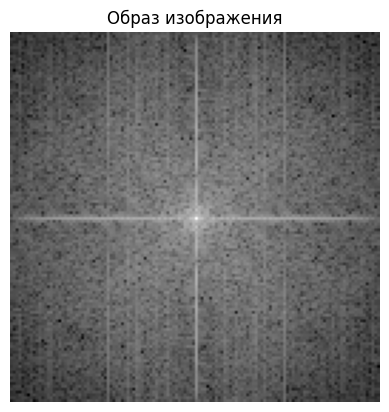

In [29]:
def show_image(img, title=None):
    plt.axis('off')
    if title is not None: plt.title(title)
    plt.imshow(img, cmap="gray")
    plt.show()

show_image(list(results.values())[0][2], "Образ изображения")

2.45485563078806 14.666753521740999
0.9825627712366166 14.652103005754935


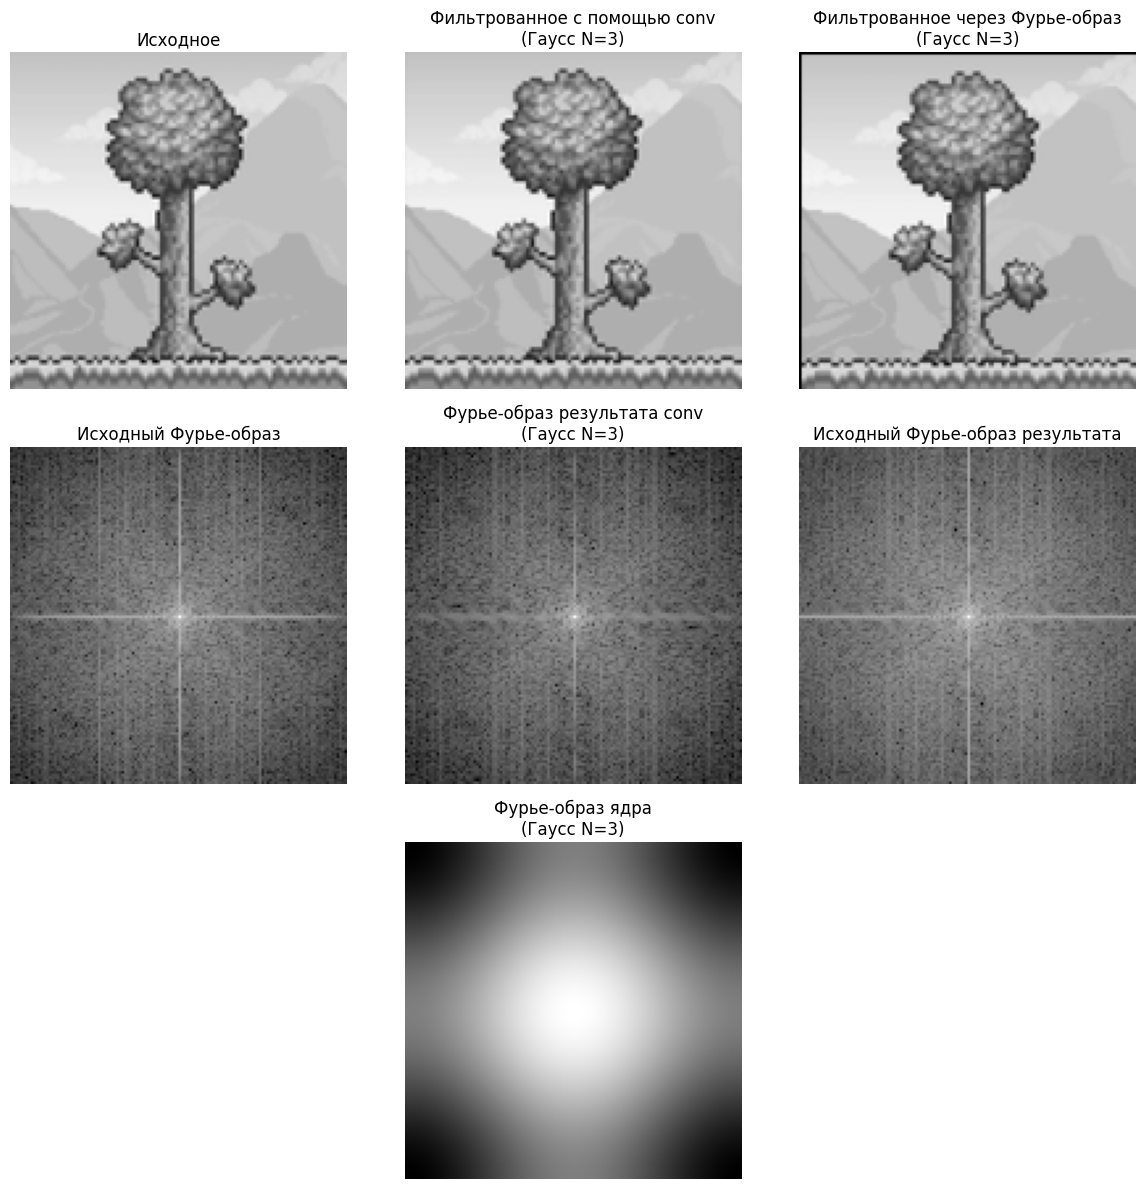

0.31755575558036586 14.660401161996694
0.9113311728649586 14.63760895000763


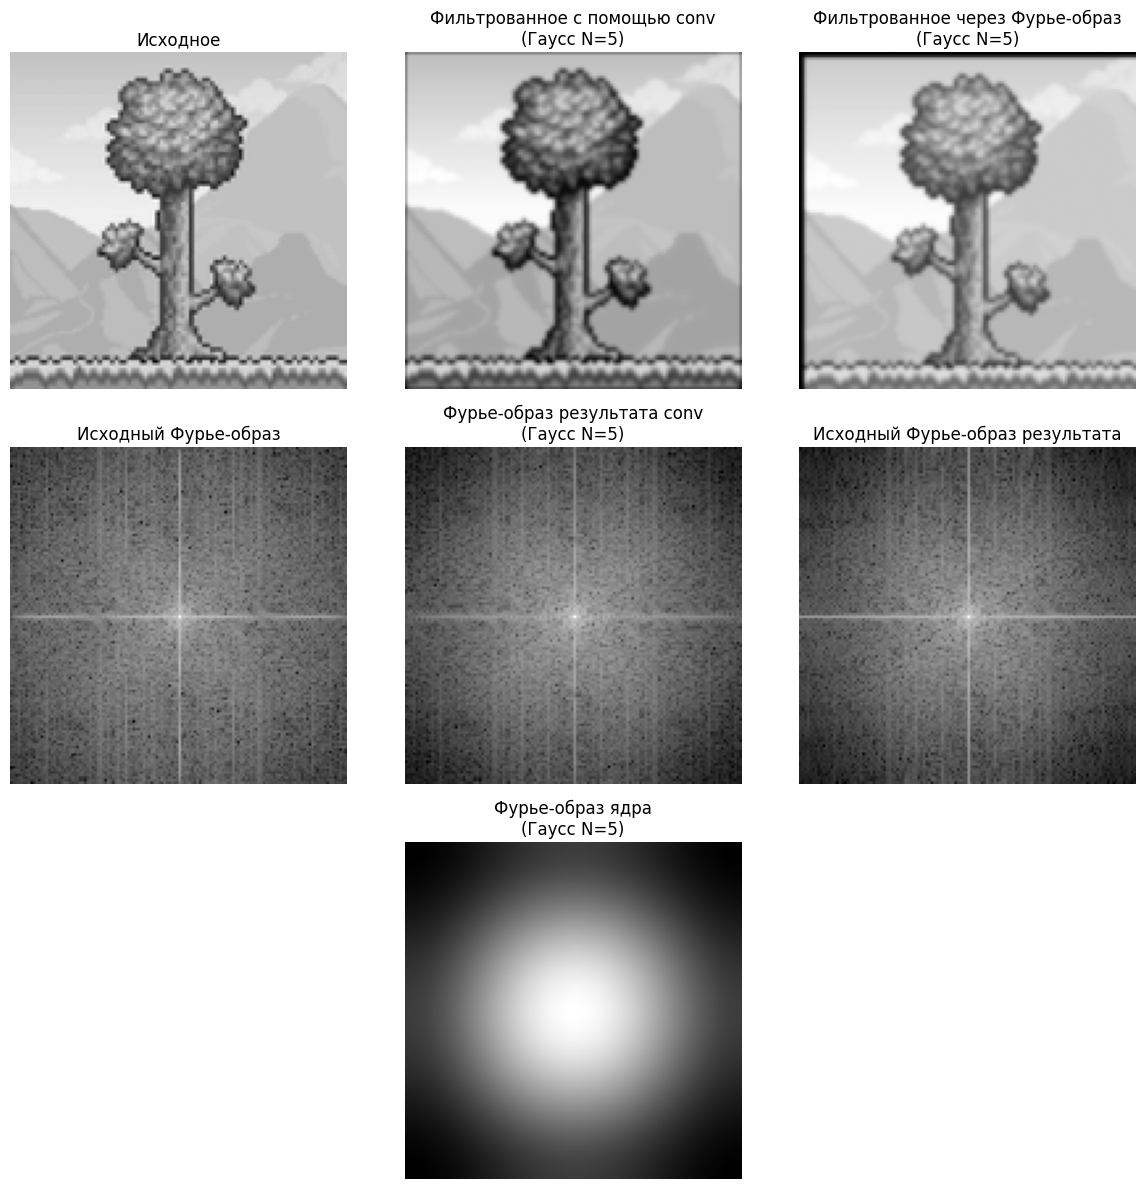

0.27267247249706755 14.65537303230153
1.2916670800153638 14.623463334608678


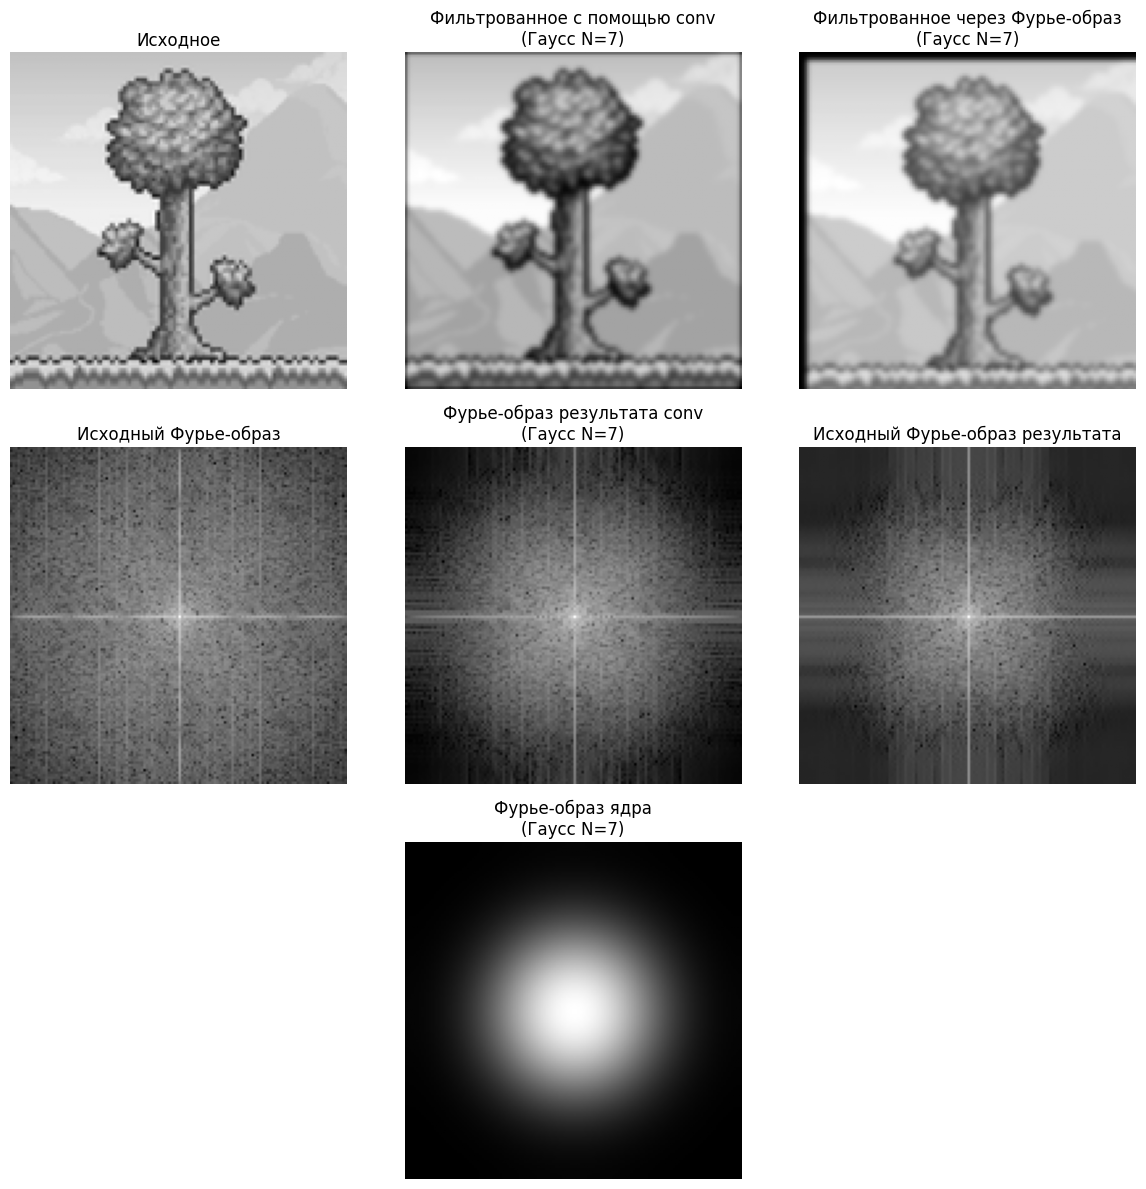

0.1762701519705981 14.65632012913888
0.39850925404660115 14.652286061541702


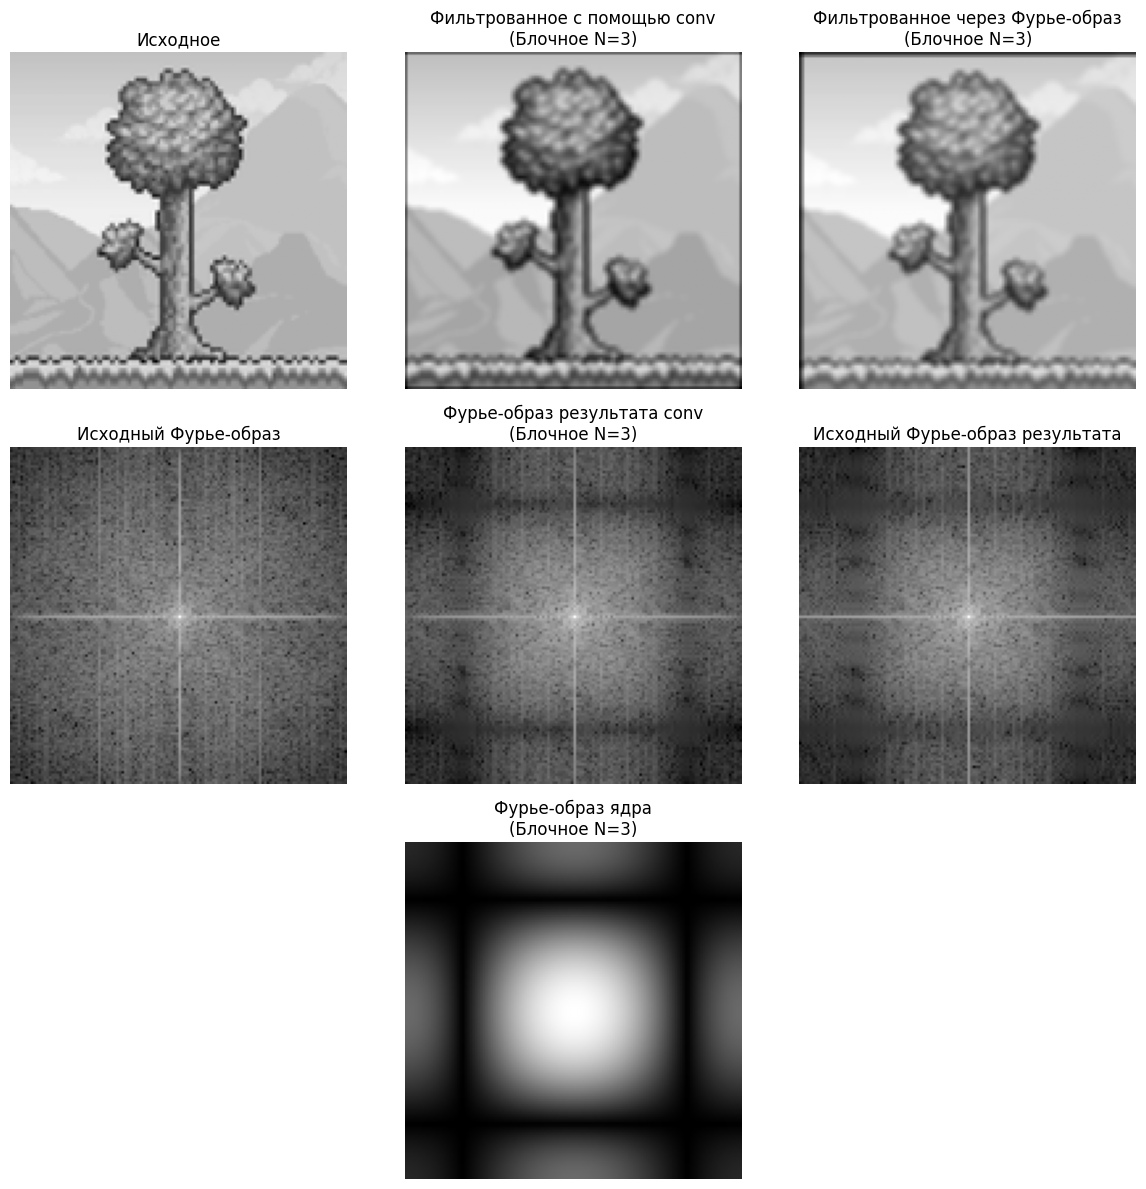

0.1472189725833579 14.64772589245774
0.7250968745090062 14.637990687505573


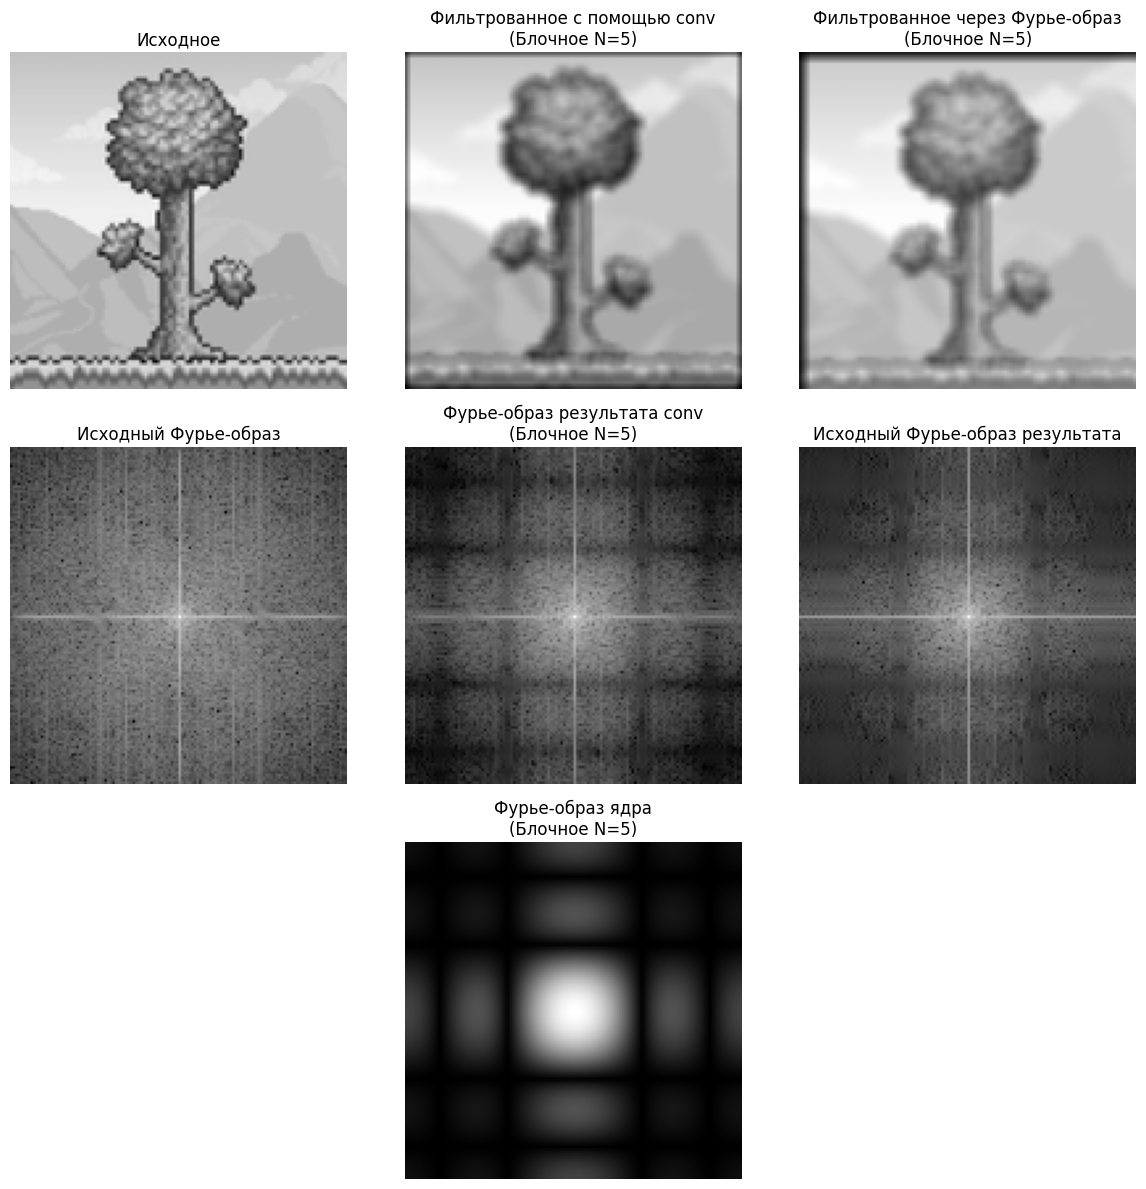

0.07121165474563076 14.6394669830346
0.6834272050426115 14.623909045982542


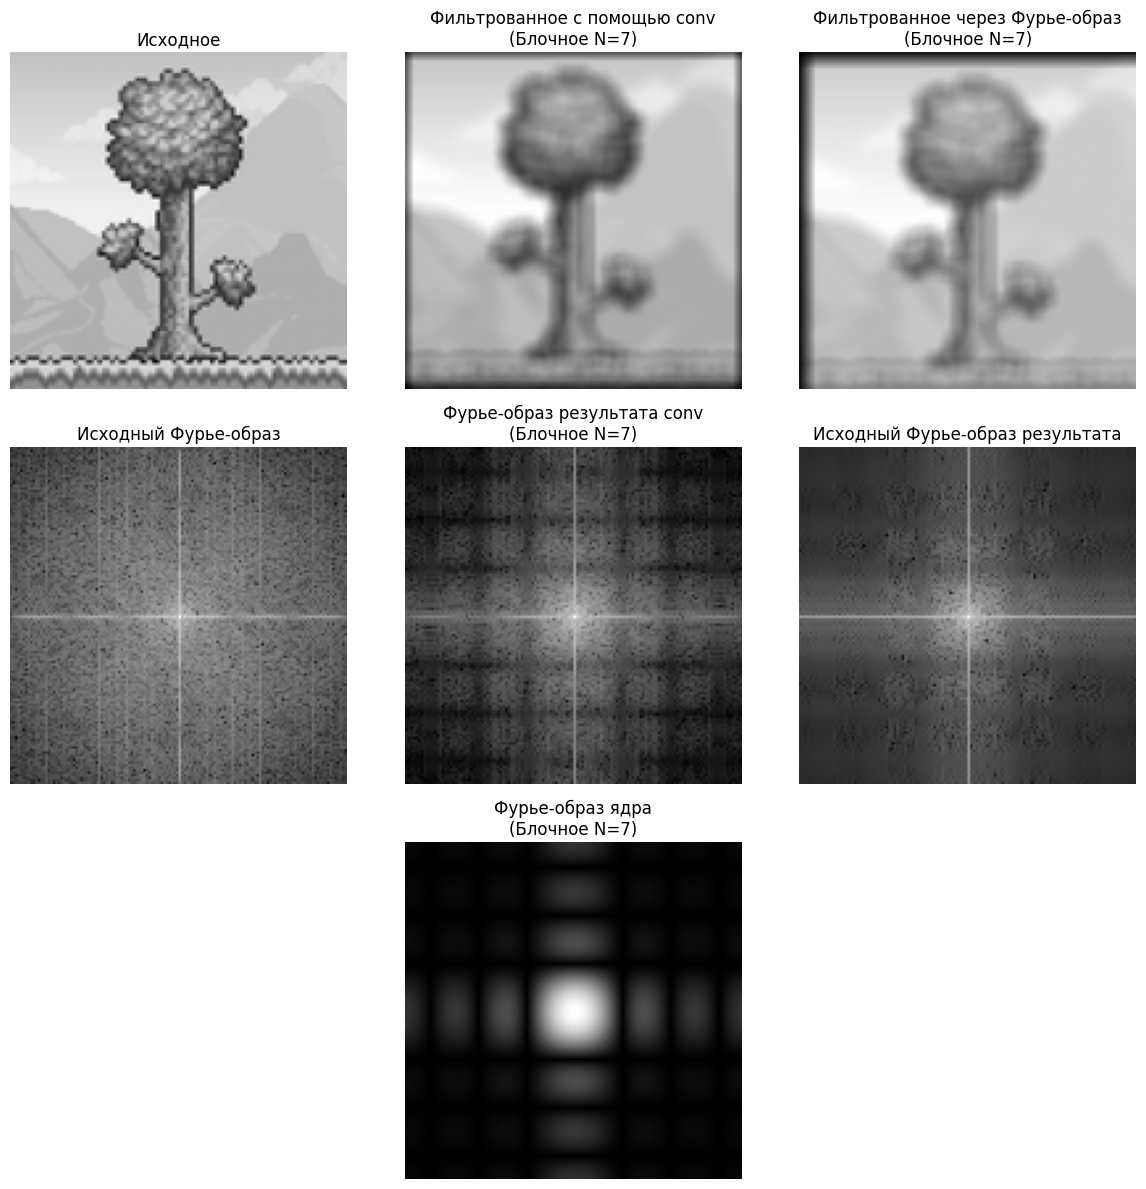

3.214892718351835 14.698844946484998
3.215328042113889 14.651527888890579


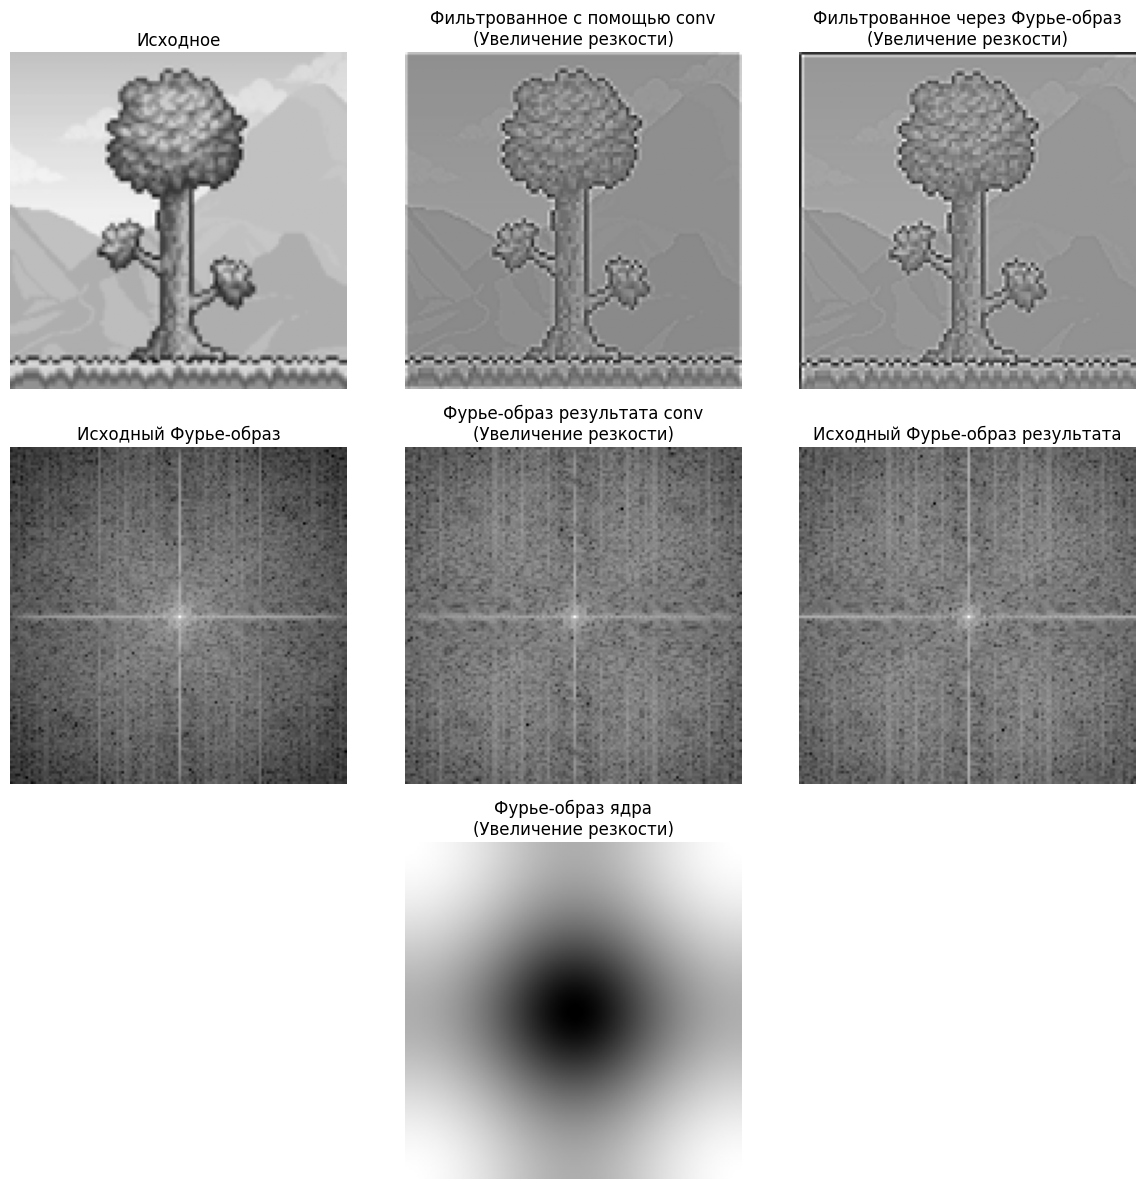

4.714964963644802 12.329245574026473
3.9687599078842166 11.930726253150805


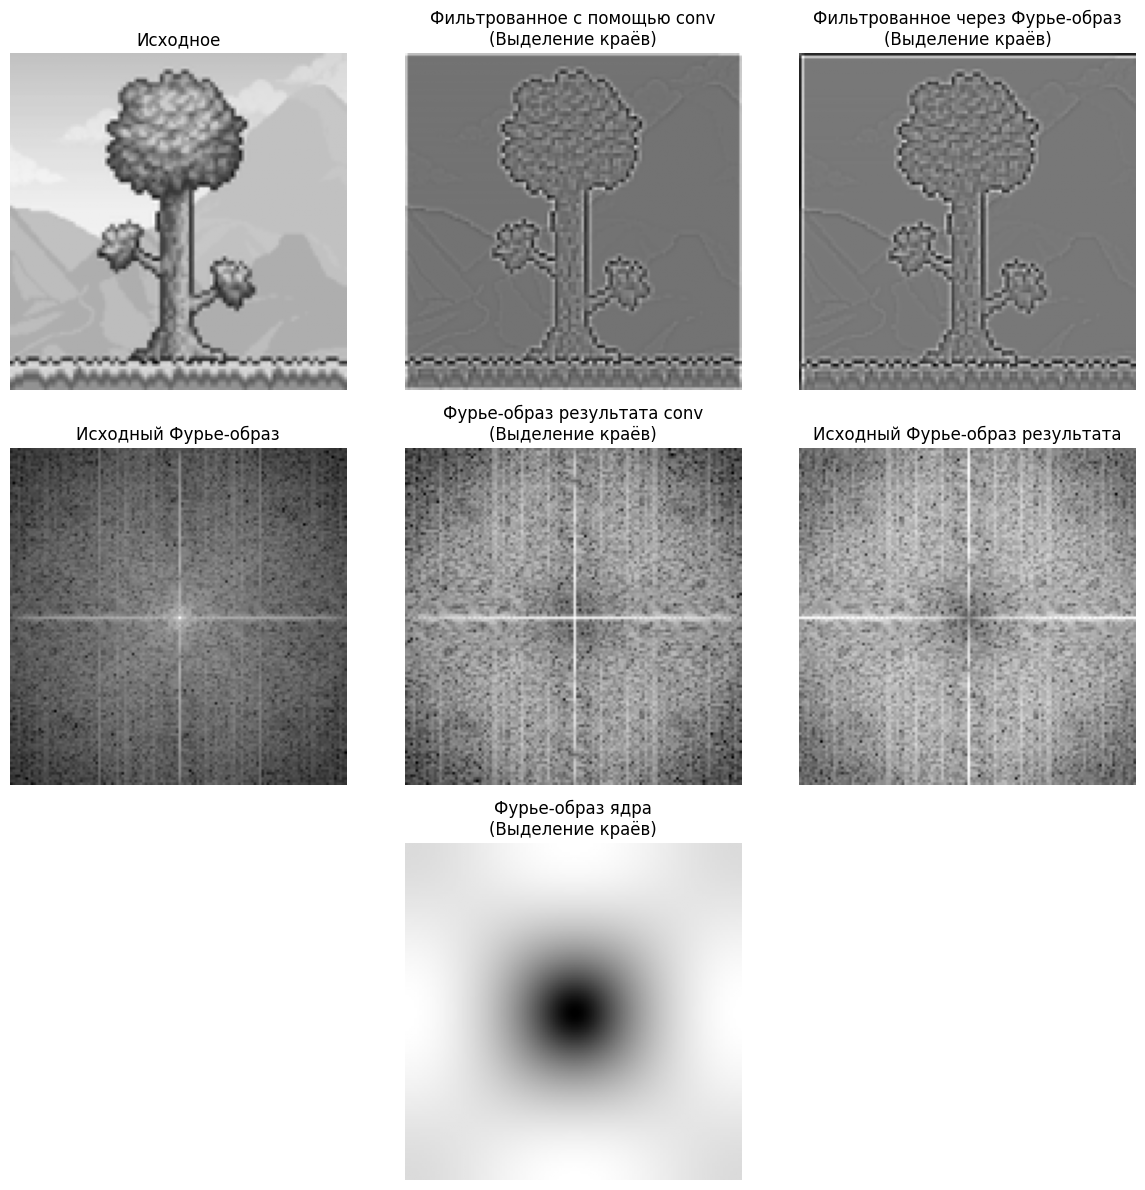

2.384512061047234 14.674172177001793
2.296447915765131 14.55912078835412


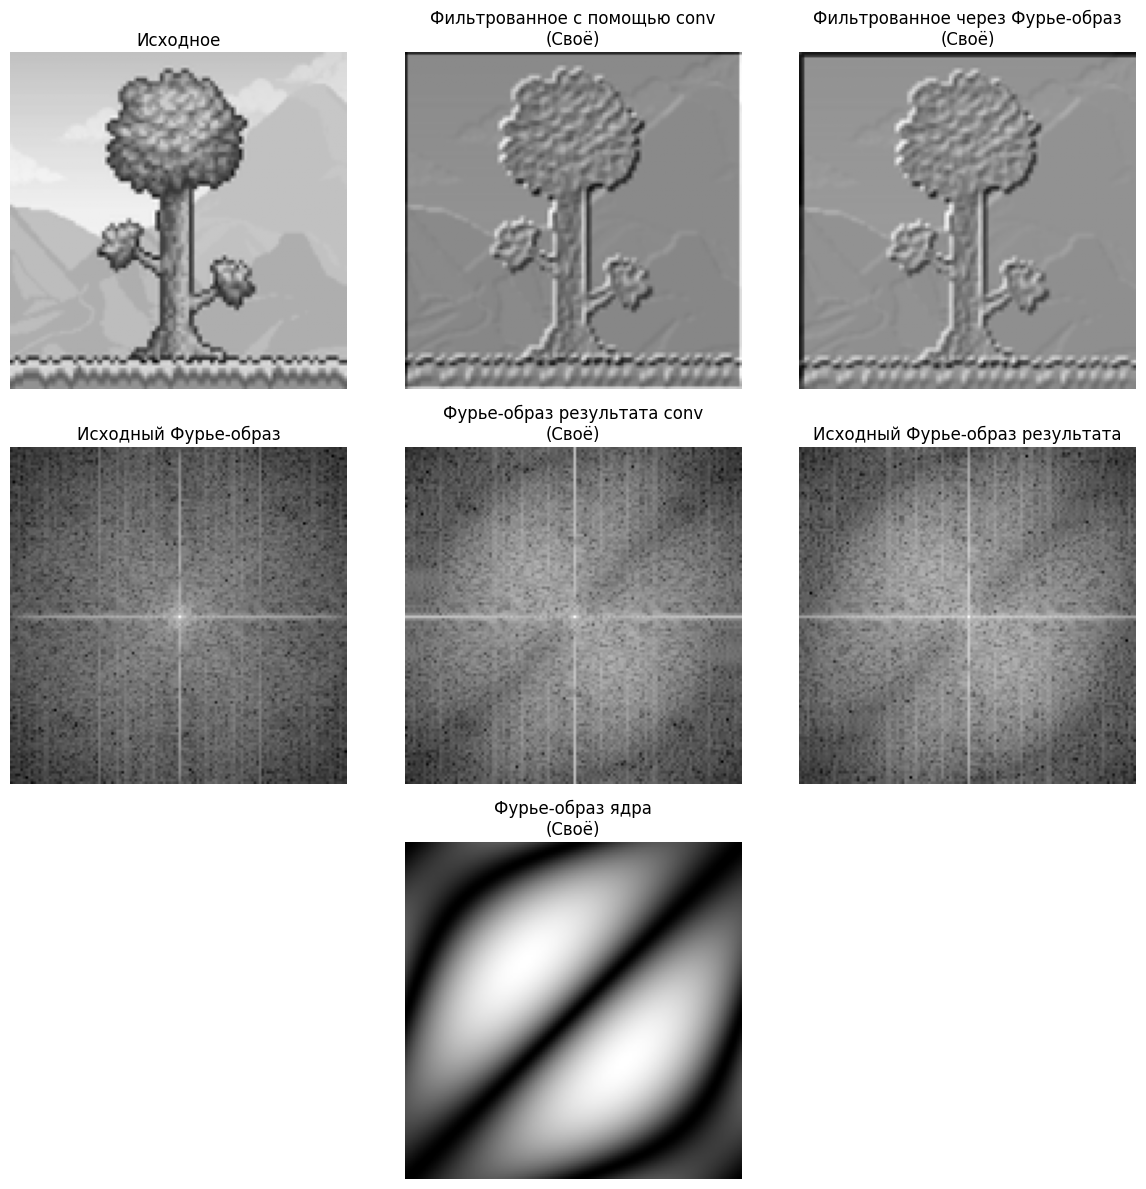

In [30]:
def show_images(
        image, image_conv, image_fft, 
        image_f, image_conv_f, image_fft_f, 
        image_f_k, name
):
    plt.figure(figsize=(12, 12))
    h, w = 3, 3

    plt.subplot(h, w, 1)
    plt.axis('off')
    plt.title("Исходное")
    plt.imshow(image, cmap="gray")
    
    plt.subplot(h, w, 2)
    plt.axis('off')
    plt.title(f"Фильтрованное с помощью conv\n({name})")
    plt.imshow(image_conv.real * 255, cmap="gray")
    
    plt.subplot(h, w, 3)
    plt.axis('off')
    plt.title(f"Фильтрованное через Фурье-образ\n({name})")
    plt.imshow(image_fft.real * 255, cmap="gray")
    
    plt.subplot(h, w, 4)
    plt.axis('off')
    plt.title("Исходный Фурье-образ")
    plt.imshow(image_f.real / np.max(image_f) * 255, cmap="gray")
    
    plt.subplot(h, w, 5)
    plt.axis('off')
    plt.title(f"Фурье-образ результата conv\n({name})")
    plt.imshow(image_conv_f.real / np.max(image_conv_f) * 255, cmap="gray")
    
    plt.subplot(h, w, 6)
    plt.axis('off')
    plt.title("Исходный Фурье-образ результата")
    plt.imshow(image_fft_f.real / np.max(image_fft_f) * 255, cmap="gray")
    
    plt.subplot(h, w, 8)
    plt.axis('off')
    plt.title(f"Фурье-образ ядра\n({name})")
    plt.imshow(image_f_k.real / np.max(image_f_k) * 255, cmap="gray")
    
    plt.tight_layout()
    plt.show()
    
for name in results.keys():
    result_conv, result_fft, image_f, image_f_kernel = results[name]
    
    result_conv_f = get_log_abs_fourier(fft.fftshift(fft.fft2(result_conv)))
    result_fft_f = get_log_abs_fourier(fft.fftshift(fft.fft2(result_fft)))
    
    show_images(
        image, result_conv, result_fft, 
        image_f, result_conv_f, result_fft_f, 
        image_f_kernel, name
    )